# Discrete Wavelet Transform

### Introduction
Wavelets are mathematical functions generated from a mother wavelet by dilations and translations. These wavelet functions are calculated in order to break down a given function or time-series signal into different scale components. One of the techniques used for multi-level decomposition is Two-Dimensional DWT (2D-DWT).

### Popular Wavelets for EEG:
- **Daubechies** (db4, db6) – Good for transient detection
- **Symlet** (sym5) – Balanced smoothness and localization
- **Coiflet** (coif3) – Useful for biomedical signals
- **Morlet** (for CWT) – Used to visualize ictal events

# Need for EWT
Since EEG signals are non-stationery, one of the most appropriate method for extracting characteristics from EEG raw data is DWT. Unlike Fourier Transformation, Discrete Wavelet Transform captures both time and frequency localization making it suitable for detecting onset of seizures or sharp waves. Wavelets are finite in duration and can model abrupt changes.

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [2]:
#importing preprocessed dataset
df = pd.read_parquet(r"C:\Users\Diya Ghorpade\Research Project\eeg_dataset_cleaned .parquet")
print(df.head())

   # FP1-F7     F7-T7         T7-P7     P7-O1    FP1-F3     F3-C3     C3-P3  \
0 -0.000007 -0.000009 -2.363858e-05 -0.000009 -0.000005 -0.000024 -0.000017   
1 -0.000075  0.000126 -4.102564e-06 -0.000015  0.000043 -0.000034  0.000006   
2 -0.000013  0.000024  1.953602e-07  0.000038 -0.000010 -0.000010  0.000013   
3 -0.000021  0.000009 -5.958486e-05 -0.000074 -0.000021  0.000004 -0.000039   
4  0.000119  0.000047 -9.826618e-05  0.000078  0.000141  0.000128 -0.000092   

      P3-O1    FP2-F4         F4-C4  ...           --4     PZ-OZ   FC1-Ref  \
0 -0.000002 -0.000013 -3.379731e-05  ...  1.953602e-07 -0.000009  0.000003   
1  0.000015  0.000032 -3.301587e-05  ...  0.000000e+00 -0.000009  0.000003   
2  0.000056 -0.000035  1.152625e-05  ... -2.500000e-07 -0.000009  0.000003   
3 -0.000088 -0.000017  1.934066e-05  ... -5.000000e-07 -0.000009  0.000003   
4 -0.000028  0.000083  1.953602e-07  ... -7.500000e-07 -0.000009  0.000003   

    FC2-Ref  FC5-Ref   FC6-Ref       CP1-Ref   CP2-Ref  

# EEG Wavelet Processing

A class for processing EEG signals using the Discrete Wavelet Transform (DWT)  
for seizure detection applications.

### Attributes
- **wavelet_type** (`str`): Type of wavelet to use (default: `'db4'`).
- **decomposition_level** (`int`): Number of decomposition levels.
- **sampling_freq** (`int`): Sampling frequency of EEG data in Hz.
- **feature_names** (`list`): List of feature names for extracted features.


In [45]:
class EEGWaveletProcessor:
   
    
    def __init__(self, wavelet_type: str = 'db4', decomposition_level: int = 5, 
                 sampling_freq: int = 256):
       
        self.wavelet_type = wavelet_type
        self.decomposition_level = decomposition_level
        self.sampling_freq = sampling_freq
        self.feature_names = []
        
        # Validate wavelet type
        if wavelet_type not in pywt.wavelist():
            raise ValueError(f"Wavelet {wavelet_type} not available in PyWavelets. "
                           f"Available wavelets: {pywt.wavelist()}")

# EEG Signal Decomposition Using DWT

The Discrete Wavelet Transform (DWT) decomposes EEG signals into:
- **Approximations (A)**: Low-frequency components (e.g., background EEG activity)
- **Details (D)**: High-frequency components (e.g., spikes, seizures, artifacts)

## Decomposition Levels
EEG signals are typically decomposed into 5–7 levels, corresponding to standard clinical frequency bands:

| Level | Frequency Range (Hz) | Clinical Relevance         |
|-------|----------------------|----------------------------|
| A5/D5 | 0-4                  | Delta waves (slow wave sleep)|
| A4/D4 | 4-8                  | Theta waves (drowsiness)    |
| A3/D3 | 8-16                 | Alpha waves (relaxed state) |
| A2/D2 | 16-32                | Beta waves (active thinking)|
| A1/D1 | 32-64                | Gamma waves (cognitive processing)|

# EEG Signal Decomposition using Discrete Wavelet Transform (DWT)

This function decomposes an EEG signal using the Discrete Wavelet Transform (DWT).

### Parameters
- **signal** (`numpy.ndarray`): 1D array of EEG data.  
- **wavelet** (`str`): Wavelet type (default: `'db4'`).  
- **level** (`int`): Decomposition level (default: `5`).  
- **sampling_rate** (`int`): Sampling frequency in Hz (default: `256`).

### Returns
- **dict**: A dictionary containing:
  - `'approximation'`: Final approximation coefficients (`cA`).
  - `'details'`: List of detail coefficients (`cD`) for each level.
  - `'frequency_bands'`: List of frequency ranges for each level.


In [49]:
def decompose_eeg_signal(signal, wavelet='db4', level=5, sampling_rate=256):
   
    # Validate input
    if not isinstance(signal, np.ndarray) or signal.ndim != 1:
        raise ValueError("Input signal must be a 1D numpy array")
    
    if wavelet not in pywt.wavelist():
        raise ValueError(f"Wavelet {wavelet} not available. Choose from: {pywt.wavelist()}")
    
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Extract coefficients
    cA = coeffs[0]  # Approximation coefficients
    cDs = coeffs[1:]  # Detail coefficients (from fine to coarse)
    
    # Calculate frequency bands for each decomposition level
    freq_bands = []
    nyquist = sampling_rate / 2
    
    for i in range(1, level+1):
        upper = nyquist / (2 ** (i-1))
        lower = nyquist / (2 ** i)
        freq_bands.append(f"{lower:.1f}-{upper:.1f} Hz")
    
    return {
        'approximation': cA,
        'details': cDs,
        'frequency_bands': freq_bands
    }

# Extract features from wavelet-decomposed EEG signal for seizure detection.
Parameters: decomposition: Dictionary returned by decompose_eeg_signal()
Returns: Dictionary of extracted features with descriptive keys

In [31]:
def extract_wavelet_features(decomposition):
   
    cA = decomposition['approximation']
    cDs = decomposition['details']
    
    # Combine all coefficients for some features
    all_coeffs = np.concatenate([cA] + cDs)
    
    features = {}
    
    # 1. Basic Statistics Features
    features['mean_abs_coeff'] = np.mean(np.abs(all_coeffs))
    features['std_coeff'] = np.std(all_coeffs)
    features['skewness'] = stats.skew(all_coeffs)
    features['kurtosis'] = stats.kurtosis(all_coeffs)
    
    # 2. Energy Features
    total_energy = np.sum(np.square(all_coeffs))
    features['total_energy'] = total_energy
    
    # Energy for each frequency band
    for i, cD in enumerate(cDs, start=1):
        band_energy = np.sum(np.square(cD))
        features[f'band_{i}_energy'] = band_energy
        features[f'band_{i}_energy_ratio'] = band_energy / total_energy if total_energy > 0 else 0
    
    # Approximation energy
    features['approx_energy'] = np.sum(np.square(cA))
    
    # 3. Entropy Features (important for seizure detection)
    features['shannon_entropy'] = stats.entropy(np.square(all_coeffs) + 1e-12)  # Add small value to avoid log(0)
    features['log_energy_entropy'] = np.sum(np.log(np.square(all_coeffs) + 1e-12))
    
    # 4. Cross-band Features (useful for seizure patterns)
    if len(cDs) >= 2:
        # Ratio of adjacent bands
        for i in range(len(cDs)-1):
            ratio = features[f'band_{i+1}_energy'] / (features[f'band_{i+2}_energy'] + 1e-12)
            features[f'band_{i+1}_{i+2}_ratio'] = ratio
    
    # 5. Statistical Features per Band
    for i, cD in enumerate(cDs, start=1):
        features[f'band_{i}_mean_abs'] = np.mean(np.abs(cD))
        features[f'band_{i}_std'] = np.std(cD)
        features[f'band_{i}_max'] = np.max(cD)
    
    return features

In [33]:
# Create a test EEG signal (2 seconds of 10Hz + 40Hz activity)
fs = 256
t = np.linspace(0, 2, 2*fs, endpoint=False)
eeg_signal = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*40*t)

# 1. Decompose the signal 
decomposition = decompose_eeg_signal(eeg_signal, wavelet='db4', level=5, sampling_rate=fs)

# 2. Extract features using the feature extraction function
features = extract_wavelet_features(decomposition)

# 3. Print the features in an organized way
print("\n" + "="*50)
print("EXTRACTED WAVELET FEATURES FOR SEIZURE DETECTION")
print("="*50)

print("\n BASIC STATISTICS :")
print(f"{'Mean absolute coeff':<30}: {features['mean_abs_coeff']:.4f}")
print(f"{'Standard deviation':<30}: {features['std_coeff']:.4f}")
print(f"{'Skewness':<30}: {features['skewness']:.4f}")
print(f"{'Kurtosis':<30}: {features['kurtosis']:.4f}")

print("\n ENERGY FEATURES :")
print(f"{'Total energy':<30}: {features['total_energy']:.4f}")
print(f"{'Approximation energy':<30}: {features['approx_energy']:.4f}")

# Print energy features for each band
num_bands = len(decomposition['details'])
for i in range(1, num_bands+1):
    print(f"{f'Band {i} energy':<30}: {features[f'band_{i}_energy']:.4f}")
    print(f"{f'Band {i} energy ratio':<30}: {features[f'band_{i}_energy_ratio']:.4f}")

print("\n ENTROPY FEATURES :")
print(f"{'Shannon entropy':<30}: {features['shannon_entropy']:.4f}")
print(f"{'Log energy entropy':<30}: {features['log_energy_entropy']:.4f}")

print("\n CROSS-BAND RATIOS :")
for i in range(1, num_bands):
    print(f"{f'Band {i}/{i+1} ratio':<30}: {features[f'band_{i}_{i+1}_ratio']:.4f}")

print("\n PER-BAND STATISTICS :")
for i in range(1, num_bands+1):
    print(f"\nBand {i} Statistics:")
    print(f"{'  Mean absolute':<28}: {features[f'band_{i}_mean_abs']:.4f}")
    print(f"{'  Standard deviation':<28}: {features[f'band_{i}_std']:.4f}")
    print(f"{'  Maximum value':<28}: {features[f'band_{i}_max']:.4f}")

print("\n" + "="*50)
print(f"Total features extracted: {len(features)}")
print("="*50)


EXTRACTED WAVELET FEATURES FOR SEIZURE DETECTION

 BASIC STATISTICS :
Mean absolute coeff           : 0.4695
Standard deviation            : 0.8543
Skewness                      : 0.2927
Kurtosis                      : 7.6919

 ENERGY FEATURES :
Total energy                  : 397.4665
Approximation energy          : 73.3028
Band 1 energy                 : 34.3542
Band 1 energy ratio           : 0.0864
Band 2 energy                 : 212.2943
Band 2 energy ratio           : 0.5341
Band 3 energy                 : 19.9417
Band 3 energy ratio           : 0.0502
Band 4 energy                 : 54.5262
Band 4 energy ratio           : 0.1372
Band 5 energy                 : 3.0474
Band 5 energy ratio           : 0.0077

 ENTROPY FEATURES :
Shannon entropy               : 4.4343
Log energy entropy            : -1733.5870

 CROSS-BAND RATIOS :
Band 1/2 ratio                : 0.1618
Band 2/3 ratio                : 10.6458
Band 3/4 ratio                : 0.3657
Band 4/5 ratio                : 17

Visualize the wavelet features extracted

In [35]:
def visualize_wavelet_features(features, decomposition):
   
    plt.figure(figsize=(18, 12))
    plt.suptitle('EEG Wavelet Feature Visualization for Seizure Detection', fontsize=16, y=1.02)
    
    # Create grid layout
    gs = GridSpec(3, 3, figure=plt.gcf())
    
    # 1. Plot 1: Coefficient Energy Distribution (Pie Chart)
    ax1 = plt.subplot(gs[0, 0])
    band_energies = [features[f'band_{i}_energy'] for i in range(1, len(decomposition['details'])+1)]
    band_energies.append(features['approx_energy'])
    labels = [f'Band {i}' for i in range(1, len(decomposition['details'])+1)] + ['Approx']
    ax1.pie(band_energies, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Energy Distribution Across Bands')
    
    # 2. Plot 2: Time-Frequency Heatmap
    ax2 = plt.subplot(gs[0, 1:])
    all_coeffs = [decomposition['approximation']] + decomposition['details']
    coeff_lengths = [len(c) for c in all_coeffs]
    max_len = max(coeff_lengths)
    
    # Create matrix for heatmap (padding shorter coefficients with NaNs)
    heatmap_data = []
    for coeff in reversed(all_coeffs):  # Reverse to show low freq at bottom
        padded = np.pad(coeff, (0, max_len - len(coeff)), constant_values=np.nan)
        heatmap_data.append(padded)
    
    sns.heatmap(np.abs(heatmap_data), ax=ax2, cmap='viridis', cbar_kws={'label': 'Coefficient Magnitude'})
    ax2.set_title('Wavelet Coefficient Magnitude Heatmap')
    ax2.set_xlabel('Time (samples)')
    ax2.set_ylabel('Frequency Band')
    ax2.set_yticks(np.arange(len(all_coeffs))+0.5)
    ax2.set_yticklabels([f'Band {i}' for i in range(len(all_coeffs)-1, 0, -1)] + ['Approx'])
    
    # 3. Plot 3: Feature Value Bar Plot
    ax3 = plt.subplot(gs[1, :])
    # Select main features to display
    selected_features = {
        'Total Energy': features['total_energy'],
        'Shannon Entropy': features['shannon_entropy'],
        'Mean Abs Coeff': features['mean_abs_coeff'],
        'Skewness': features['skewness'],
        'Kurtosis': features['kurtosis']
    }
    # Add band energy ratios
    for i in range(1, min(4, len(decomposition['details'])+1)):  # Show first 3 bands
        selected_features[f'Band {i} Energy'] = features[f'band_{i}_energy']
    
    sns.barplot(x=list(selected_features.keys()), y=list(selected_features.values()), ax=ax3, palette='coolwarm')
    ax3.set_title('Key Feature Values')
    ax3.set_ylabel('Value')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Plot 4: Cross-Band Ratios
    if len(decomposition['details']) >= 2:
        ax4 = plt.subplot(gs[2, 0])
        ratios = []
        ratio_labels = []
        for i in range(1, len(decomposition['details'])):
            ratios.append(features[f'band_{i}_{i+1}_ratio'])
            ratio_labels.append(f'Band {i}/{i+1}')
        sns.barplot(x=ratio_labels, y=ratios, ax=ax4, palette='mako')
        ax4.set_title('Cross-Band Energy Ratios')
        ax4.set_ylabel('Ratio')
        ax4.axhline(1.0, color='red', linestyle='--', alpha=0.5)  # Reference line
    
    # 5. Plot 5: Per-Band Statistics
    ax5 = plt.subplot(gs[2, 1:])
    bands = []
    means = []
    stds = []
    maxs = []
    for i in range(1, len(decomposition['details'])+1):
        bands.append(f'Band {i}')
        means.append(features[f'band_{i}_mean_abs'])
        stds.append(features[f'band_{i}_std'])
        maxs.append(features[f'band_{i}_max'])
    
    x = np.arange(len(bands))
    width = 0.25
    ax5.bar(x - width, means, width, label='Mean Abs')
    ax5.bar(x, stds, width, label='Std Dev')
    ax5.bar(x + width, maxs, width, label='Max Value')
    ax5.set_title('Per-Band Statistical Features')
    ax5.set_xticks(x)
    ax5.set_xticklabels(bands)
    ax5.legend()
    
    plt.tight_layout()
    plt.show()

C:\Users\Diya Ghorpade\AppData\Local\Temp\ipykernel_400\2381905457.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(selected_features.keys()), y=list(selected_features.values()), ax=ax3, palette='coolwarm')
C:\Users\Diya Ghorpade\AppData\Local\Temp\ipykernel_400\2381905457.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio_labels, y=ratios, ax=ax4, palette='mako')


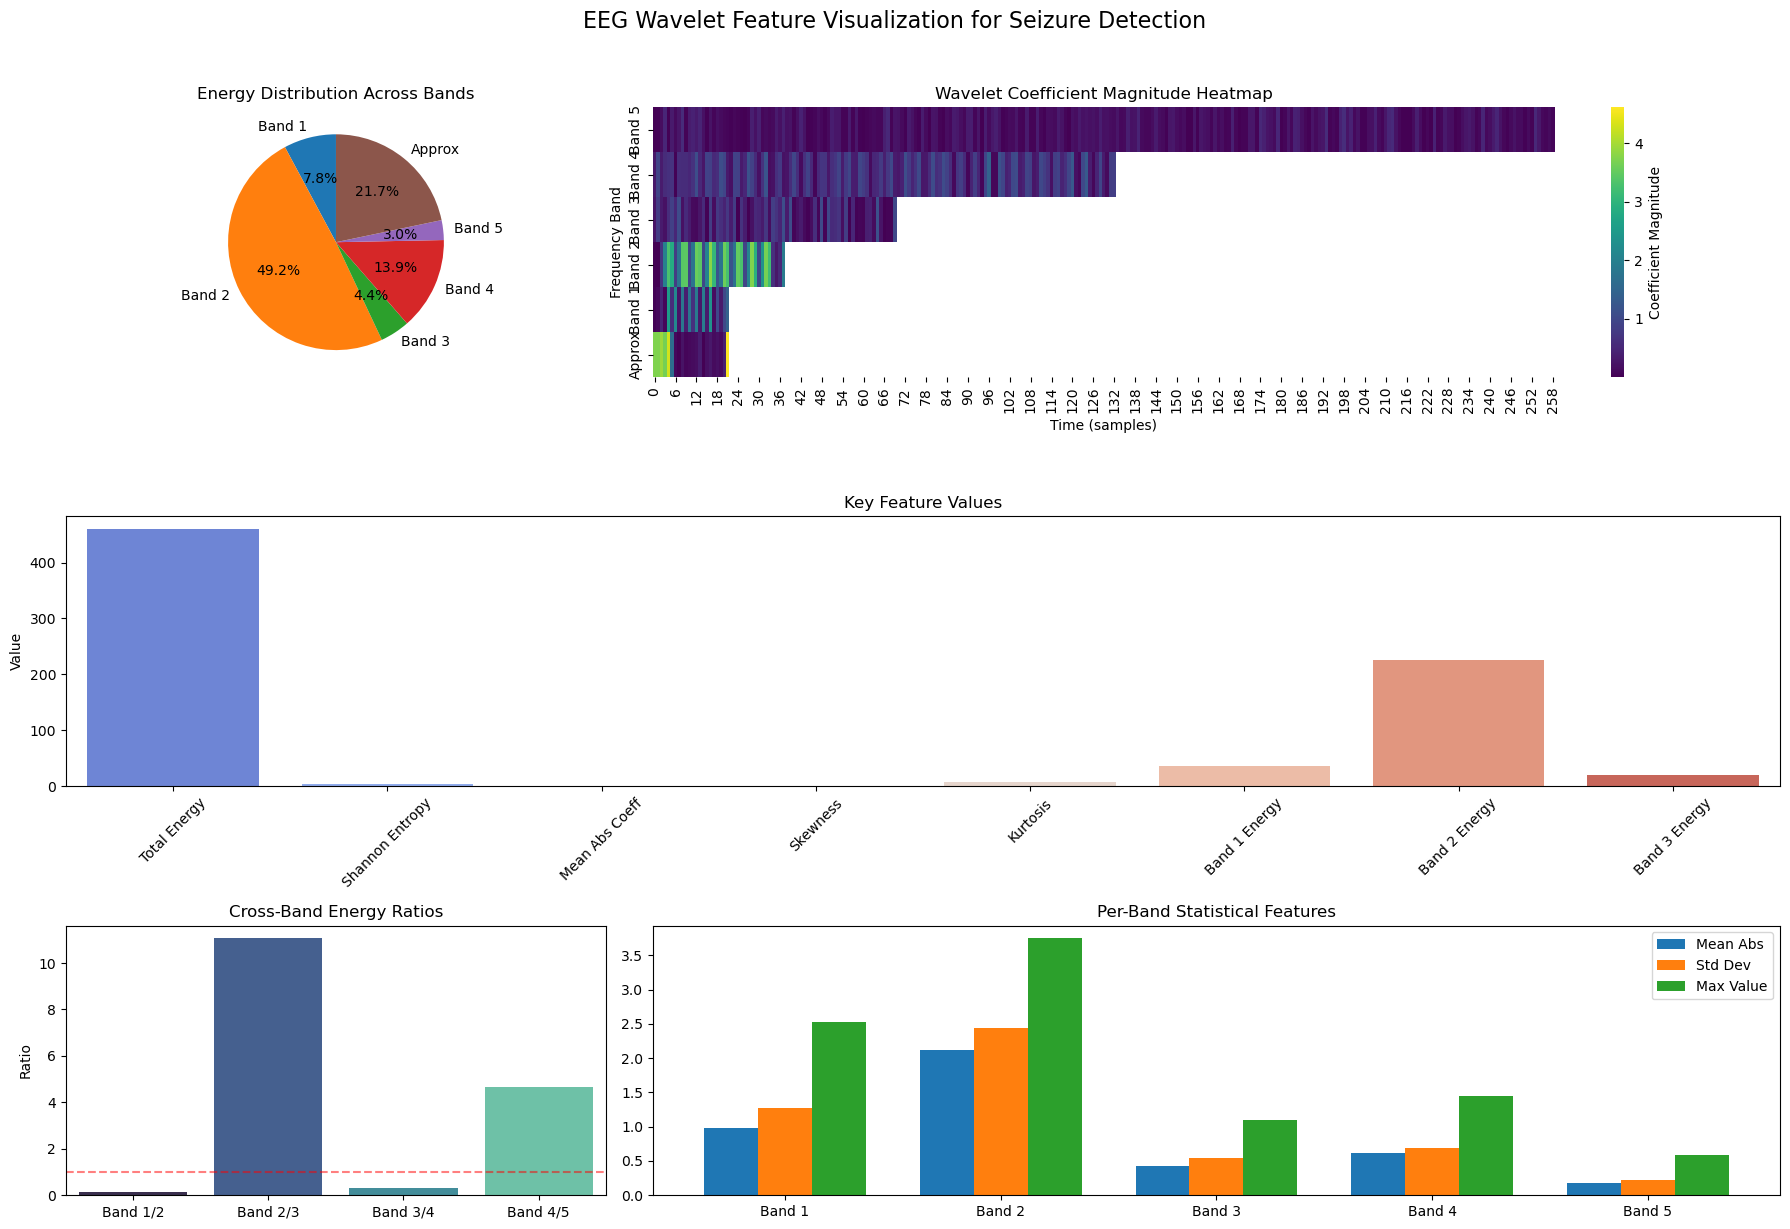

In [8]:
# Generate test signal
fs = 256  # sampling frequency
t = np.linspace(0, 2, 2*fs, endpoint=False)
eeg_signal = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*40*t) + 0.2*np.random.normal(size=len(t))

# Decompose and extract features
decomposition = decompose_eeg_signal(eeg_signal, wavelet='db4', level=5, sampling_rate=fs)
features = extract_wavelet_features(decomposition)

# Visualize
visualize_wavelet_features(features, decomposition)